# WHAT'S HERE & NEXT TODO

Try to read out the full set of generation logits. All the logits, at the end of every forward pass, in the layer that the SAE is hooked to. instead of just the last forward pass.

- DONE: Implement with Dataset - hotpot QA and USMLE
- DONE: Play around with Temperature, Penalty, % above max activation coefficient. 240 was way above. But as described in the Streamlit tutorial: 
> Note that we can choose the value of steering_coefficient based on the maximum activation of the latent we're steering on (it's usually wise to choose quite close to the max activation, but not so far above that you steer the model far out of distribution - however this varies from latent to latent, e.g. in the case of this particular latent we'll find it still produces coherent output quite far above the max activation value). If we didn't have neuronpedia then we couldn't do this, and we'd be better off measuring the max activation over some suitably large dataset to guide what value to choose for our steering coefficient.

DONE: 3 different steering latents (minimum)
DONE: Maybe 100 Questions.
FILE EVAL_steered_jsonl.ipynb: --> Evaluation metrics ! 


## ToDo's for V2
(above stuff was for V1)
This stuff is to be implemented in V2.1 V2 was working well for single debug runs, so keep for reference -- V2.1 will contain the loop and all necessary improvements for a full experiment. 

1. Change output. Since it's a lot more data, makes more sense to have a folder of output files for each run. i.e a folder 'V2_0to60Hotpot_pirate'. Then for each answer have a jsonL file for metadata and then one for each prompt's answers (APPEND manual evaluation), and then one for each answer's (unsteered, steered1, steered2) logits. If needed, these can then later be converted and written to another JSONL of format SAE_act_unsteered, steered_1, etc.
2. First evaluate right wrong, only consider right unsteered answers for further eval
3. Do it with the Hotpot but also the USMLE prompt set.

Statistical Eval:

4. Same as last time, different mechanisms.
    
    4a. However, you could try and evaluate top and 'second quartile top' latents layer for layer, or across all layers. You could also try to ignore the layer in which the steering takes place. 
    4b. You could do the same with the logits, instead of SAE-dictionary latents.
5. Have a closer look at the logits/latents that activate for the token that contains the condensed answer of the USMLE answers (i.e. "(B)" or "(A)") and compare latents between steered and unsteered. 
6. Clean up the forward pass top latents bar graphs (already in this ipynb, but move them to another eval script that reads from the jsonl files)

    Idea: make it a scatter graph. Showing the activation strength of the top latents of each forward pass in one go. (all the points for each forward pass should be quite close together)
    **Show it for each hookpoint layer. Currently only showing the first layer in V2 script.**


7. If at all promising, repeat with non-Instruction trained 9b model, or even try another one like Llama.

7. Use an LLM to change the input? i.e make it use slang. Make it ask the Q in a different way, using yet another LLM. 

8. The same, but with 'random'? or better non-random? ablation (set neurons to 0)

# Setup
Conda Env == lets_drift_env_V1 
(Which is a clone of arena_env1_1_1c)

In [1]:
%run LetsDriftGemma2_imports.py
import json # TODO: Move to imports.py
import os # TODO: Move to imports.py


starts with a j..jeje .. f_JTQGGDeycTxPCozthrzqWQhmLpOkaVKXRq
Successfully imported all the imports


#### Choose Model here

In [2]:
""" # TODO Implement chooser
if model2use == "gemma2_2b_it": 
    tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")
    model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-2b-it",
    device_map="auto",
        torch_dtype=t.bfloat16,
    )
    print("gemma2_2b_it loaded")
elif model2use == "gemma2_9b_it":
    tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b-it")
    model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-9b-it",
    device_map="auto",
    torch_dtype=t.bfloat16,
    )
    print("gemma2_9b_it loaded")
"""
#from sae_lens import SAE

model2use = "gemma2_9b_it_131k"

if model2use == "gemma2_2b":
    model_name = "gemma-2-2b"
    gemma_2_2b = HookedSAETransformer.from_pretrained(model_name, device=device)

    gemmascope_sae_release = "gemma-scope-2b-pt-res-canonical"
    gemmascope_sae_id = "layer_20/width_16k/canonical"

    gemma_2_2b_sae = SAE.from_pretrained(gemmascope_sae_release, gemmascope_sae_id, device=str(device))[0]
elif model2use == "gemma2_9b_it_16k":  
    model_name = "gemma-2-9b-it"
    gemma_2_2b = HookedSAETransformer.from_pretrained(model_name, device=device, dtype="float16")  # dtype float16 helps with CUDA RAM issues..
    gemmascope_sae_release = "gemma-scope-9b-it-res-canonical"
    gemmascope_sae_id = "layer_9/width_16k/canonical"
    gemma_2_2b_sae = SAE.from_pretrained(gemmascope_sae_release, gemmascope_sae_id, device=str(device))[0]

elif model2use == "gemma2_9b_it_131k":  
    model_name = "gemma-2-9b-it"
    gemma_2_2b = HookedSAETransformer.from_pretrained(model_name, device=device, dtype="float16")  # dtype float16 helps with CUDA RAM issues..
    gemmascope_sae_release = "gemma-scope-9b-it-res-canonical" 
    gemmascope_sae_id = "layer_9/width_131k/canonical"
    gemma_2_2b_sae = SAE.from_pretrained(gemmascope_sae_release, gemmascope_sae_id, device=str(device))[0]
    gemmascope_sae_release = "gemma-scope-9b-it-res-canonical" 
    gemmascope_sae_id_layer31 = "layer_31/width_131k/canonical"
    gemma_2_9bit_sae_layer31 = SAE.from_pretrained(gemmascope_sae_release, gemmascope_sae_id_layer31, device=str(device))[0]
    gemmascope_sae_id_layer20 = "layer_20/width_131k/canonical"
    gemma_2_9bit_sae_layer20 = SAE.from_pretrained(gemmascope_sae_release, gemmascope_sae_id_layer20, device=str(device))[0]
else:
    raise ValueError(f"Invalid model2use value: {model2use}. Must be one of: 'gemma2_2b', 'gemma2_9b_it'")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-9b-it into HookedTransformer


In [3]:
from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory

# Get directory and convert to dataframe
df = pd.DataFrame.from_records(
    {k: v.__dict__ for k, v in get_pretrained_saes_directory().items()}
).T

# Filter for gemma-2-9b-it model and display saes_map
gemma_9b_saes = df[df['model'] == 'gemma-2-9b-it']
print("\nSAEs map for gemma-2-9b-it model:")
for idx, row in gemma_9b_saes.iterrows():
    print(f"\n{idx}:")
    print(row['saes_map'])


SAEs map for gemma-2-9b-it model:

gemma-scope-9b-it-res-canonical:
{'layer_9/width_16k/canonical': 'layer_9/width_16k/average_l0_88', 'layer_20/width_16k/canonical': 'layer_20/width_16k/average_l0_91', 'layer_31/width_16k/canonical': 'layer_31/width_16k/average_l0_76', 'layer_9/width_131k/canonical': 'layer_9/width_131k/average_l0_121', 'layer_20/width_131k/canonical': 'layer_20/width_131k/average_l0_81', 'layer_31/width_131k/canonical': 'layer_31/width_131k/average_l0_109'}


###### FRAGE für Schacht; was ist Average_l0_88, canonical?

# CONFIG: Generate_Kwargs, Random Seed, EnaDebug

#### Necessary Functions & Utilities - GENERAL 


In [4]:

# Define output file name and folder
folder_names = ["60to75USMLE_pirate_v2_fixed", "77to82USMLE_negative_v2_fixed", "77to82Hotpot_negative_v2_fixed"]
default_temp = 0.02 # was 0.1 in v2first run, 0.075 in '60to75'. 0.02 in 75to77, 0.02 for all "_fixed"
default_freq_penalty = 1.5 # was 2.0 in v2 first run. 1.5 in "_fixed"
def set_KWARGS_to_default():
    global GENERATE_KWARGS  # Declare that we want to modify the global variable
    GENERATE_KWARGS = dict(temperature=default_temp, freq_penalty=default_freq_penalty, verbose=False)

GENERATE_KWARGS = dict(temperature=default_temp, freq_penalty=default_freq_penalty, verbose=False)#(temperature=0.5, freq_penalty=2.0, verbose=False)
seed_int: int = 42
t.manual_seed(seed_int)

In [5]:
%run SAE_Lens_Scripts.py
# Test that dashboard script was added to the workspace correctly

ENA_DEBUG_PRINT = False # additional print statements for debugging
#max_queries=10 # amount of qs to ask from the dataset !defined together with dataset now
max_tokens=1300 # amount of tokens to generate for each answer -- first pirate run with 50

#latent_idx = 12082 # Steered latent 12082 == Dogs in Gemma2 2b #! overwritten in run-script but still installed as default
# ! TODO: Add all these (incld GENERATE_KWARGS) to the yaml output file for trackenings


In [6]:
#display_dashboard(sae_release=gemmascope_sae_release, sae_id=gemmascope_sae_id)
# display_dashboard(sae_release=gemmascope_sae_release, sae_id=gemmascope_sae_id, latent_idx=latent_idx)

#### Necessary Functions - Steering

In [7]:
#from solutions.py part of part32_interp_with_saes because solution in Streamlit page isnt commplete - the steering_hook solution was misssing?
def steering_hook(
    activations: Float[Tensor, "batch pos d_in"],
    hook: HookPoint,
    sae: SAE,
    latent_idx: int,
    steering_coefficient: float,
) -> Tensor:
    """
    Steers the model by returning a modified activations tensor, with some multiple of the steering vector added to all
    sequence positions.
    """
    return activations + steering_coefficient * sae.W_dec[latent_idx]

In [8]:
def generate_with_steering_and_return_logits(
    model: HookedSAETransformer,
    sae: SAE,
    prompt: str,
    latent_idx: int,
    steering_coefficient: float = 1.0,
    max_new_tokens: int = 50,
):
    """
    Generates text with steering and returns output text and logits
    of the last token from each forward pass as simple lists.
    """
    _steering_hook = partial(
        steering_hook,
        sae=sae,
        latent_idx=latent_idx,
        steering_coefficient=steering_coefficient,
    )
    
    #last_token_logits = [[]]  # Initialize with an empty list inside
    layer9_logits = [[]] # will save only last forward pass' logits
    layer20_logits = [[]]
    layer31_logits = [[]]
    def logit_capture_hook(activations, hook): #TODO: HARDCODED LAYER9
        # Only capture logits for the last token, convert to 1D list
        logits = activations[:, -1, :].squeeze(0).detach().cpu().tolist()
        layer9_logits[0].append(logits)
        return activations
    def logit_capture_hook_layer20(activations, hook): #TODO: HARDCODED LAYER20
        logits = activations[:, -1, :].squeeze(0).detach().cpu().tolist()
        layer20_logits[0].append(logits)
        return activations
    def logit_capture_hook_layer31(activations, hook): #TODO: HARDCODED LAYER31
        logits = activations[:, -1, :].squeeze(0).detach().cpu().tolist()
        layer31_logits[0].append(logits)
        return activations
    

    with model.hooks(fwd_hooks=[
        (sae.cfg.hook_name, _steering_hook),
        (f"blocks.{sae.cfg.hook_layer}.hook_resid_post", logit_capture_hook),
        (f"blocks.{gemma_2_9bit_sae_layer20.cfg.hook_layer}.hook_resid_post", logit_capture_hook_layer20), #TODO: HARDCODED gemma_2_9bit_sae_layer20 here
        (f"blocks.{gemma_2_9bit_sae_layer31.cfg.hook_layer}.hook_resid_post", logit_capture_hook_layer31), #TODO: HARDCODED gemma_2_9bit_sae_layer31 here
    ]):
        input_tokens = model.to_tokens(prompt).clone()
        generated_tokens = model.generate(
            input_tokens,
            max_new_tokens=max_new_tokens,
            **GENERATE_KWARGS
        )
        
        # Get just the generated tokens (excluding prompt tokens)
        answer_tokens = generated_tokens[0, input_tokens.shape[1]:]

        # Convert only the answer tokens to string 
        # ==>NOTE: Updated in V2, previously always got the input_text in the answer, as well. 
        output_text = model.to_string(answer_tokens) 
        answer_tokens_cpu =  generated_tokens[0, input_tokens.shape[1]:].detach().cpu().tolist()
    return output_text, answer_tokens_cpu, layer9_logits[0], layer20_logits[0], layer31_logits[0] 
# Layer logits return as lists (not tensors!): [output_text, [[logits_1], [logits_2], ...]]

In [9]:
def compute_sae_activations_from_logits(
    sae: SAE,
    last_token_logits: list[list[float]],
    return_all: bool = False
) -> list[float] | list[list[float]]:
    """
    Compute SAE activations from a list of logits lists.
    
    Args:
        sae: The SAE model
        last_token_logits: List of logit lists from each forward pass
        return_all: If True, return activations for all forward passes
                   If False, return only activations from final forward pass
    
    Returns:
        If return_all=False: List of SAE activations for final token
        If return_all=True: List of lists containing SAE activations for each token
    """
    # Convert logits to activations through SAE
    sae_activations = []
    
    for logits in last_token_logits:
        # Convert list to tensor and add batch dimension
        logits_tensor = t.tensor(logits).unsqueeze(0).to(sae.W_enc.device)
        
        # Compute SAE activations
        acts = sae.encode(logits_tensor)
        # Convert to 1D list
        acts_list = acts.squeeze(0).cpu().tolist()
        sae_activations.append(acts_list)
        
    if return_all:
        return sae_activations
    else:
        # Return only the last token's activations
        return sae_activations[-1]

In [10]:
"""
# NOT USED IN V2, (yet) 
def get_top_latents(sae_acts, k=10):
    # Remove batch dimension if present
    if len(sae_acts.shape) > 1:
        sae_acts = sae_acts[0]  # Take first batch element
    
    # Get top k latents and their activations
    values, indices = t.topk(sae_acts, k)
    
    # Format as list of (index, value) tuples
    return [(int(idx.item()), float(val.item())) for idx, val in zip(indices, values)]"""

'\n# NOT USED IN V2, (yet) \ndef get_top_latents(sae_acts, k=10):\n    # Remove batch dimension if present\n    if len(sae_acts.shape) > 1:\n        sae_acts = sae_acts[0]  # Take first batch element\n    \n    # Get top k latents and their activations\n    values, indices = t.topk(sae_acts, k)\n    \n    # Format as list of (index, value) tuples\n    return [(int(idx.item()), float(val.item())) for idx, val in zip(indices, values)]'

##### CONFIG: Folder Handling / init

ToDo V2_looped
Change output structure. Since it's a lot more data, makes more sense to have a folder of output files for each run. i.e a folder 'V2_0to60Hotpot_pirate'. Then for each answer have a jsonL file for metadata and then one for each prompt's answers (APPEND manual evaluation), and then one for each answer's (unsteered, steered1, steered2) logits. If needed, these can then later be converted and written to another JSONL of format SAE_act_unsteered, steered_1, etc.

In [11]:
# DEFINE ALL FILE NAMES 
# TODO: manual implementation. Could automate, depending on the hookpoints and other options contained in the file and folder name, chosen previously.
bI_know_what_Im_doin_mode = True
def folder_making_handler(folder_names_list):
    for folder_name in folder_names_list:
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
            print(f"Created {folder_name} directory")
        else:
            print(f"WARNING! Folder {folder_name} already exists. Ensure it's empty to make your evaluation life easier later!!")
            #if not bI_know_what_Im_doin_mode:
                #Raise ValueError("Check folder names above are correctly set in CONFIG and EMPTY before running loop")
# Create output folder if it doesn't exist


folder_making_handler(folder_names)


WARNING! Folder 60to75USMLE_pirate_v2_fixed already exists. Ensure it's empty to make your evaluation life easier later!!
Created 77to82USMLE_negative_v2_fixed directory
Created 77to82Hotpot_negative_v2_fixed directory


##### Main Eval Function to be placed into a loop script handling the datasets

In [12]:
try:
    print("max_tokens:", max_tokens)
    for i in range(len(folder_names)):
        print("output_folder:", folder_names[i])
except NameError as e:
    print(f"Error: Variable not defined - {e}")


max_tokens: 1300
output_folder: 60to75USMLE_pirate_v2_fixed
output_folder: 77to82USMLE_negative_v2_fixed
output_folder: 77to82Hotpot_negative_v2_fixed


In [13]:
def evaluate_with_steering(  
    prompt: str, 
    prompt_id: int, 
    ref_answer: str, 
    latent_id : int, 
    bWriteMetaData:bool, #Handle in loop..: execute only on first prompt for this folder
    progress_bar: tqdm,  # Add progress_bar parameter
    num_steered_examples: int=2, 
    steering_coeff : int = 240,
    output_path: str ="output_path_not_set",
    dataset_name : str = "not set", 
    comment : str="no comment",
    incremental_temperature : bool = False,
    max_n_tkns : int = max_tokens, # ! Note: Local var max_tokens
):
    # File handling
    if bWriteMetaData: 
        with open(os.path.join(output_path, 'metadata.jsonl'), 'a') as file:
            data = {
                'Dataset': dataset_name,
                'Starting_Prompt_ID': prompt_id,
                'Model' : model_name, # !Note: Local Var in Jupy Notebook
                'SAE_release' : gemmascope_sae_release,# !Note: Local VAr. **For now,** it's the SAE that's used for steering, too.
                'SAE_ID' : gemmascope_sae_id, # !Note Local var
                'Steered_Latent_ID': latent_id, 
                'Steering_coefficient': steering_coeff,
                'Max_new_tokens': max_n_tkns,
                'Temperature': GENERATE_KWARGS['temperature'], # !Note: LOcal var
                'Frequency_penalty': GENERATE_KWARGS['freq_penalty'],
                'Verbose' : GENERATE_KWARGS['verbose'],
                'Incremental_temperature' : incremental_temperature, 
                'Comment' : comment,       
                'Other HookedSAETransformers:' :  "Rel: gemma-scope-9b-it-res-canonical" + "IDs: " + gemmascope_sae_id_layer31 + " & " + gemmascope_sae_id_layer31  #!Note: Local var
            }
            file.write(json.dumps(data)) # every time you add a new data'set' like this, instead of appending, it will put this dataset it in a new {curly braket}. However, a new line is only started using \n (jsonL !)
            file.write('\n')
            file.flush()  # Ensure data is written to disk
    with open(os.path.join(output_path, 'ID'+str(prompt_id)+'_out.jsonl'), 'a') as file:
        data = {
            'Prompt_ID': prompt_id,
            'Prompt': prompt,
            'Ref_answer': ref_answer,
        }
        file.write(json.dumps(data)) # every time you add a new data'set' like this, instead of appending, it will put this dataset it in a new {curly braket}. However, a new line is only started using \n (jsonL !)
        file.write('\n')
        file.flush()  # Ensure data is written to disk

        """
        #TODO: all the outputs like logits_l9_steered have manual names specifc to this HookedSAEtrans.
        no_steering_output, logits_l9_steered, logits_l20, logits_l31 = generate_with_steering_and_return_logits(
            gemma_2_2b, #NOTE: Actually gemma2_9b_it now.... 
            gemma_2_2b_sae,
        # Save some RAM:
        #t.cuda.empty_cache()
        #del sae_acts
        #file.flush()  # Ensure data is written to disk
        #progress_bar.update(1)  # Update the passed progress bar
    _steering_coeff : int = 1
        # FOR LOOP to come here...:
        for i in range(num_steered_examples+1):
        }


                    'SAE_Activations_No_Steering' : sae_acts.tolist(),
        file.write(json.dumps(data_unsteered))"""
        # Save some RAM:
        #t.cuda.empty_cache()
        #del sae_acts
        #file.flush()  # Ensure data is written to disk
        #progress_bar.update(1)  # Update the passed progress bar
        _steering_coeff = steering_coeff
        # FOR LOOP to come here...:
        for i in range(num_steered_examples+1):
            if i == 0: 
                typeOfAnswer = 'Answer_No_Steering'
                steering_coeff = 1
                # First, generate the normal response
                progress_bar.set_description(" ⤷ Generating:   unsteered example (1/1)")
            else:
                typeOfAnswer = 'Answer_Steered'+str(i)
                steering_coeff = _steering_coeff
                progress_bar.set_description(f" ⤷ Generating:   steered example ({i}/{num_steered_examples}) (with temperature={GENERATE_KWARGS['temperature']:.2f})")
            output_text, output_tokens, logits_l9, logits_l20, logits_l31 = generate_with_steering_and_return_logits(
                gemma_2_2b,
                gemma_2_2b_sae,
                prompt,
                latent_id,
                steering_coefficient    = steering_coeff,
                max_new_tokens      = max_n_tkns
            )
            file.write(json.dumps({typeOfAnswer : output_text})+'\n')
            file.write(json.dumps({'Output_Tokens_' + typeOfAnswer : output_tokens})+'\n')
            file.write(json.dumps({'Activations_' + typeOfAnswer + '_layer9' : logits_l9})+ '\n')
            file.write(json.dumps({'Activations_' + typeOfAnswer + '_layer20' : logits_l20})+ '\n')
            file.write(json.dumps({'Activations_' + typeOfAnswer + '_layer31' : logits_l31})+ '\n')
            file.flush()
            file.write(
                json.dumps({
                    'SAE_Activations_' + typeOfAnswer + '_layer9': compute_sae_activations_from_logits(
                        sae=gemma_2_2b_sae,
                        last_token_logits=logits_l9,
                        return_all=True  #NOTE: **SSD Storage:** returning all forward pass' latents is 30MB per Answer.
                    )
                }) + '\n'
            )
            file.write(
                json.dumps({
                    'SAE_Activations_' + typeOfAnswer + '_layer20': compute_sae_activations_from_logits(
                        sae=gemma_2_9bit_sae_layer20,
                        last_token_logits=logits_l20,
                        return_all=True
                    )
                }) + '\n'
            )
            file.write(
                json.dumps({
                    'SAE_Activations_' + typeOfAnswer + '_layer31': compute_sae_activations_from_logits(
                        sae=gemma_2_9bit_sae_layer31,
                        last_token_logits=logits_l31,
                        return_all=True
                    )
                }) + '\n'
            )
            file.flush()
            
            # Double the temperature for subsequent generations
            if incremental_temperature: 
                GENERATE_KWARGS['temperature'] *= 2 # !Note: Local var 

            progress_bar.update(1)  # Update the passed progress bar
            progress_bar.refresh()  # Force refresh the display
            
        #AFTER running through for loop, reset KWARGS for next run and empty RAM
        set_KWARGS_to_default() # !Note: Local vars are used here.. ~~ which is why this is needed
        t.cuda.empty_cache()
 

Some Latents to try...:
gemma2_9b, 

SAE 131k, layer9 res, ID 29917: Pirates, also 77558

coeff on neuropedia example: 41.5, 16.5, *4 (default settings, coeff * strength)


In [14]:
#playing around with jsonL printing...
"""
prmptid=2
latents = [0,15,155,2299.3]
with open(os.path.join(output_path, 'ID'+str(prmptid)+'_out.jsonl'), 'a') as file:
        file.write(str(latents))
        file.write('\n')
        file.write(json.dumps({str(prmptid)+'_text:' : latents})+ '\n')
        file.write(json.dumps({str(prmptid)+'_text:' : latents}))
        file.flush()"""

"\nprmptid=2\nlatents = [0,15,155,2299.3]\nwith open(os.path.join(output_path, 'ID'+str(prmptid)+'_out.jsonl'), 'a') as file:\n        file.write(str(latents))\n        file.write('\n')\n        file.write(json.dumps({str(prmptid)+'_text:' : latents})+ '\n')\n        file.write(json.dumps({str(prmptid)+'_text:' : latents}))\n        file.flush()"

In [15]:
#### Debug example
"""
m_n_tkns=40
prompt = "The football manager who recruited David Beckham managed Manchester United during what timeframe?"
answer = "from 1986 to 2013"
prompt_id = 2
#for i in tqdm(range(3), "Generating steered examples..."): .. use tqdm for each prompt from dataset
output_string, last_token_logits = generate_with_steering_and_return_logits(
    model=gemma_2_2b,           # Add required model parameter
    sae=gemma_2_2b_sae,        # Add required sae parameter
    prompt=prompt,
    latent_idx=29917,
    steering_coefficient=150,
    max_new_tokens=m_n_tkns          # Optional, will use default if not specified
)"""

'\nm_n_tkns=40\nprompt = "The football manager who recruited David Beckham managed Manchester United during what timeframe?"\nanswer = "from 1986 to 2013"\nprompt_id = 2\n#for i in tqdm(range(3), "Generating steered examples..."): .. use tqdm for each prompt from dataset\noutput_string, last_token_logits = generate_with_steering_and_return_logits(\n    model=gemma_2_2b,           # Add required model parameter\n    sae=gemma_2_2b_sae,        # Add required sae parameter\n    prompt=prompt,\n    latent_idx=29917,\n    steering_coefficient=150,\n    max_new_tokens=m_n_tkns          # Optional, will use default if not specified\n)'

In [16]:
# output_string

Debugging Code..

In [17]:
"""# Print total number of elements in the list
print(f"Number of entries in last_token_logits list: {len(last_token_logits)}")

# Print length of each list element
for i, element in enumerate(last_token_logits):
    print(f"Entry {i}: {len(element)} elements")

# Verify all list elements have same length
if len(last_token_logits) > 0:
    first_size = len(last_token_logits[0])
    all_same = all(len(elem) == first_size for elem in last_token_logits)
    print(f"\nAll entries have same length: {all_same}")"""


'# Print total number of elements in the list\nprint(f"Number of entries in last_token_logits list: {len(last_token_logits)}")\n\n# Print length of each list element\nfor i, element in enumerate(last_token_logits):\n    print(f"Entry {i}: {len(element)} elements")\n\n# Verify all list elements have same length\nif len(last_token_logits) > 0:\n    first_size = len(last_token_logits[0])\n    all_same = all(len(elem) == first_size for elem in last_token_logits)\n    print(f"\nAll entries have same length: {all_same}")'

In [18]:
"""last_token_logits is a list, cannot get dtype/shape
List contents: [tensor([[ 5.5235,  3.9231, -4.7625,  ..., -2.4402, -3.3925,  5.8776]]), tensor([[ 2.8745,  6.7737, -2.8518,  ..., -2.7508, -2.8021,  4.5817]]), tensor([[ 1.7290,  4.6683, -4.7947,  ..., -3.4908, -1.8395,  3.8488]]), tensor([[ 2.0879,  4.0467, -6.9280,  ..., -4.1043, -3.6327,  3.5437]]), tensor([[ 1.8003,  3.6028, -5.5081,  ..., -3.6028, -3.3456,  2.3640]]), tensor([[ 3.5664,  4.9417, -3.1390,  ..., -2.5826, -4.2694,  3.5524]]), tensor([[ 0.0078,  2.2015, -7.1429,  ..., -1.3113, -1.3153,  7.4675]]), tensor([[ 3.0611,  0.9554, -3.0784,  ...,  0.8068, -1.1161,  4.1193]]), tensor([[ 2.0401,  2.2659, -1.1526,  ...,  1.2560,  0.6661,  4.7253]]), tensor([[ 3.0938,  2.2308, -2.6458,  ..., -3.1746, -1.7443,  5.0207]]), tensor([[ 2.4180,  3.8399, -3.1468,  ..., -3.9202, -0.7333,  2.7800]]), tensor([[-0.2636,  1.2659, -2.5432,  ..., -5.2459, -1.2787,  4.4353]]), tensor([[ 1.3946,  3.8055, -5.8489,  ..., -2.1971, -2.2274,  4.9362]]), tensor([[ 0.8545,  4.0491, -3.4124,  ..., -3.7952, -2.9559,  4.9348]]), tensor([[ 3.8536,  2.2942, -2.2659,  ..., -2.1199, -1.0018,  6.3122]]), tensor([[ 2.7666,  2.7425, -0.6956,  ..., -1.2723, -1.9525,  7.3132]]), tensor([[ 2.5791,  2.7864, -4.7915,  ..., -1.3797, -3.6171,  4.9821]]), tensor([[ 2.5469,  4.4651, -5.2815,  ..., -2.8272, -5.2108,  3.9089]]), tensor([[ 1.7383,  3.4295, -3.5076,  ..., -3.6443, -3.3358,  5.2548]]), tensor([[ 2.5533,  2.3714, -4.0328,  ..., -2.9491, -3.1913,  5.0285]]), tensor([[ 2.1685,  2.6443, -4.8699,  ..., -0.7049, -1.6478,  4.3151]]), tensor([[ 1.3457,  2.0989, -3.0413,  ..., -1.5418, -1.0419,  5.9265]]), tensor([[ 2.0953,  3.1033, -4.8396,  ..., -1.2889, -3.6874,  6.0339]]), tensor([[ 0.7598,  3.2635, -3.2972,  ..., -1.3875, -3.1444,  5.8405]]), tensor([[ 1.5645,  3.7151, -4.0879,  ..., -2.8441, -2.8011,  5.3552]]), tensor([[ 1.8330,  3.2408, -4.6331,  ..., -1.8152, -2.0926,  4.7211]]), tensor([[ 0.6309,  3.6092, -3.9251,  ..., -2.8655, -0.4686,  5.7497]]), tensor([[ 1.0411,  3.4437, -2.6653,  ..., -2.1287, -2.4530,  6.9069]]), tensor([[ 2.7105,  5.0491, -2.3108,  ..., -2.0989, -1.6771,  4.3491]]), tensor([[ 2.6434,  4.8538, -4.9466,  ..., -2.2454, -1.7814,  3.7985]]), tensor([[ 2.2962,  4.5989, -2.3382,  ..., -2.0643, -1.0116,  4.5315]]), tensor([[ 1.5586,  4.3655, -4.2869,  ..., -2.1556, -0.9667,  4.5946]]), tensor([[ 4.3985,  1.5364, -0.4280,  ..., -2.4412, -4.3300,  3.5241]]), tensor([[ 1.8584,  0.6585, -4.0174,  ..., -4.3641, -2.3759,  8.2390]]), tensor([[ 3.4112,  0.7835, -5.7591,  ..., -1.8807, -5.6776,  4.9135]]), tensor([[ 1.9873,  1.5325, -5.2195,  ..., -3.0543, -3.1171,  5.5568]]), tensor([[ 1.8672,  2.3812, -3.6917,  ..., -2.4153, -2.1405,  4.7966]]), tensor([[ 2.6731,  2.0110, -4.7591,  ..., -1.2283, -3.1747,  7.0046]]), tensor([[ 0.5000,  4.4944, -2.3011,  ..., -0.9256, -3.1327,  5.8562]]), tensor([[ 2.0962,  2.5452, -2.7962,  ..., -1.7820, -2.2147,  6.4050]]), tensor([[ 3.2613,  3.0699, -2.6350,  ..., -3.0047, -3.2587,  4.1291]]), tensor([[ 2.2676,  2.3538, -0.2854,  ..., -2.3543, -2.7884,  2.5847]]), tensor([[ 1.4522,  3.7808, -2.8069,  ..., -2.7171, -1.6439,  3.1325]]), tensor([[ 1.4952,  3.1685, -5.0237,  ..., -2.0916,  0.5997,  4.2443]]), tensor([[ 2.8335,  4.8040, -5.3929,  ..., -3.8514,  0.2208,  3.5153]]), tensor([[ 2.2652,  4.2625, -2.4710,  ..., -3.7357, -1.5648,  4.8591]]), tensor([[ 2.0489,  5.0911, -3.7898,  ..., -3.1721, -0.5575,  4.9532]]), tensor([[ 1.5528,  7.7249, -1.7464,  ..., -1.0975, -2.0541,  3.9821]]), tensor([[ 1.2959,  4.8519, -5.7854,  ..., -1.9832, -2.5751,  3.4030]])]
Shape of individual tensors: torch.Size([1, 3584])
All tensors have same shape: True
Total number of tensors in list: 49"""

'last_token_logits is a list, cannot get dtype/shape\nList contents: [tensor([[ 5.5235,  3.9231, -4.7625,  ..., -2.4402, -3.3925,  5.8776]]), tensor([[ 2.8745,  6.7737, -2.8518,  ..., -2.7508, -2.8021,  4.5817]]), tensor([[ 1.7290,  4.6683, -4.7947,  ..., -3.4908, -1.8395,  3.8488]]), tensor([[ 2.0879,  4.0467, -6.9280,  ..., -4.1043, -3.6327,  3.5437]]), tensor([[ 1.8003,  3.6028, -5.5081,  ..., -3.6028, -3.3456,  2.3640]]), tensor([[ 3.5664,  4.9417, -3.1390,  ..., -2.5826, -4.2694,  3.5524]]), tensor([[ 0.0078,  2.2015, -7.1429,  ..., -1.3113, -1.3153,  7.4675]]), tensor([[ 3.0611,  0.9554, -3.0784,  ...,  0.8068, -1.1161,  4.1193]]), tensor([[ 2.0401,  2.2659, -1.1526,  ...,  1.2560,  0.6661,  4.7253]]), tensor([[ 3.0938,  2.2308, -2.6458,  ..., -3.1746, -1.7443,  5.0207]]), tensor([[ 2.4180,  3.8399, -3.1468,  ..., -3.9202, -0.7333,  2.7800]]), tensor([[-0.2636,  1.2659, -2.5432,  ..., -5.2459, -1.2787,  4.4353]]), tensor([[ 1.3946,  3.8055, -5.8489,  ..., -2.1971, -2.2274,  4.936

In [19]:
"""# Get SAE activations for final token
final_sae_acts = compute_sae_activations_from_logits(
    sae=gemma_2_2b_sae,
    last_token_logits=last_token_logits,
    return_all=False
)

# Or get SAE activations for all tokens
all_sae_acts = compute_sae_activations_from_logits(
    sae=gemma_2_2b_sae,
    last_token_logits=last_token_logits,
    return_all=True
)"""

'# Get SAE activations for final token\nfinal_sae_acts = compute_sae_activations_from_logits(\n    sae=gemma_2_2b_sae,\n    last_token_logits=last_token_logits,\n    return_all=False\n)\n\n# Or get SAE activations for all tokens\nall_sae_acts = compute_sae_activations_from_logits(\n    sae=gemma_2_2b_sae,\n    last_token_logits=last_token_logits,\n    return_all=True\n)'

In [20]:
# !Note: move the following to Eval!

In [21]:
def plot_top_x_unique_latents(all_sae_acts, num_last_passes=10, num_top_latents=5):
    """
    Create separate plots for the specified number of different latents with highest activations.
    
    Args:
        all_sae_acts: List of numpy arrays, each containing SAE activations for one forward pass
        num_last_passes: Number of last passes to analyze (default: 10)
        num_top_latents: Number of top unique latents to plot (default: 5)
    """
    import plotly.graph_objects as go
    import numpy as np
    
    # Take only the last N passes
    last_n_passes = all_sae_acts[-num_last_passes:]
    total_passes = len(all_sae_acts)
    start_pass_idx = total_passes - num_last_passes
    
    # Calculate average absolute activation for each latent
    latent_activations = []
    num_latents = len(last_n_passes[0])
    
    for latent_idx in range(num_latents):
        avg_activation = np.mean([abs(pass_acts[latent_idx]) for pass_acts in last_n_passes])
        latent_activations.append((latent_idx, avg_activation))
    
    # Get top N unique latents by average absolute activation
    top_n_indices = [idx for idx, _ in sorted(latent_activations, 
                                            key=lambda x: x[1], 
                                            reverse=True)[:num_top_latents]]
    
    # Create a separate plot for each top latent
    for latent_idx in top_n_indices:
        fig = go.Figure()
        
        # Get values for this latent across all passes
        values = [pass_acts[latent_idx] for pass_acts in last_n_passes]
        
        # Add bar plot
        fig.add_trace(go.Bar(
            x=[f"Pass {i}" for i in range(start_pass_idx, total_passes)],
            y=values,
            name=f"Latent {latent_idx}",
            marker_color='#1f77b4'
        ))
        
        # Update layout
        fig.update_layout(
            title=f"Activation Values for Latent {latent_idx} (Last {num_last_passes} Passes)",
            xaxis_title="Forward Pass",
            yaxis_title="Activation Value",
            width=800,
            height=400,
            showlegend=False,
            xaxis=dict(
                tickangle=45,
                type='category'
            )
        )
        
        # Show the plot
        fig.show()
    
    # Print summary of top N latents
    print(f"\nSummary of top {num_top_latents} unique latents across last {num_last_passes} passes:")
    for latent_idx in top_n_indices:
        values = [pass_acts[latent_idx] for pass_acts in last_n_passes]
        avg_activation = np.mean([abs(v) for v in values])
        print(f"\nLatent {latent_idx}:")
        print(f"Average absolute activation: {avg_activation:.2f}")
        print(f"Range: {min(values):.2f} to {max(values):.2f}")

In [22]:
"""plot_top_x_unique_latents(all_sae_acts, m_n_tkns, 10)"""

'plot_top_x_unique_latents(all_sae_acts, m_n_tkns, 10)'

In [23]:
# Version 2.0: Show different colours depending on the hookpoint that the logit is from
# not yet tested (24.01.2025 addition)
"""def plot_top_x_unique_latents(all_sae_acts_dict, num_last_passes=10, num_top_latents=5):
    """
    #Create separate plots for the specified number of different latents with highest activations.
    
    #Args:
    #    all_sae_acts_dict: Dictionary with keys as layer names and values as lists of SAE activations
    #    num_last_passes: Number of last passes to analyze (default: 10)
    #    num_top_latents: Number of top unique latents to plot (default: 5)
"""
    import plotly.graph_objects as go
    import numpy as np
    
    # Define colors for different layers
    layer_colors = {
        'layer9': '#1f77b4',  # blue
        'layer20': '#2ca02c',  # green
        'layer31': '#ff7f0e'   # orange
    }
    
    # Process each layer's activations
    for layer_name, all_sae_acts in all_sae_acts_dict.items():
        # Take only the last N passes
        last_n_passes = all_sae_acts[-num_last_passes:]
        total_passes = len(all_sae_acts)
        start_pass_idx = total_passes - num_last_passes
        
        # Calculate average absolute activation for each latent
        latent_activations = []
        num_latents = len(last_n_passes[0])
        
        for latent_idx in range(num_latents):
            avg_activation = np.mean([abs(pass_acts[latent_idx]) for pass_acts in last_n_passes])
            latent_activations.append((latent_idx, avg_activation))
        
        # Get top N unique latents by average absolute activation
        top_n_indices = [idx for idx, _ in sorted(latent_activations, 
                                                key=lambda x: x[1], 
                                                reverse=True)[:num_top_latents]]
        
        # Create a separate plot for each top latent
        for latent_idx in top_n_indices:
            fig = go.Figure()
            
            # Get values for this latent across all passes
            values = [pass_acts[latent_idx] for pass_acts in last_n_passes]
            
            # Add bar plot with layer-specific color
            fig.add_trace(go.Bar(
                x=[f"Pass {i}" for i in range(start_pass_idx, total_passes)],
                y=values,
                name=f"Latent {latent_idx}",
                marker_color=layer_colors[layer_name]
            ))
            
            # Update layout
            fig.update_layout(
                title=f"Activation Values for {layer_name} Latent {latent_idx} (Last {num_last_passes} Passes)",
                xaxis_title="Forward Pass",
                yaxis_title="Activation Value",
                width=800,
                height=400,
                showlegend=False,
                xaxis=dict(
                    tickangle=45,
                    type='category'
                )
            )
            
            # Show the plot
            fig.show()
        
        # Print summary of top N latents for this layer
        print(f"\nSummary of top {num_top_latents} unique latents for {layer_name} across last {num_last_passes} passes:")
        for latent_idx in top_n_indices:
            values = [pass_acts[latent_idx] for pass_acts in last_n_passes]
            avg_activation = np.mean([abs(v) for v in values])
            print(f"\nLatent {latent_idx}:")
            print(f"Average absolute activation: {avg_activation:.2f}")
            print(f"Range: {min(values):.2f} to {max(values):.2f}")
#TODO: All this is hardcoded for the specific layers implemented. Could make dynamic, with the settings selector at the beginning of the notebook. WOuld be better for later eval to write down the layer names into the jsonl, as well
# Create dictionary of activations from different layers
all_acts_dict = {
    'layer9': layer9_sae_acts,
    'layer20': layer20_sae_acts,
    'layer31': layer31_sae_acts
}

# Plot with different colors for each layer
plot_top_x_unique_latents(all_acts_dict, num_last_passes=m_n_tkns, num_top_latents=10)"""

'\n    import plotly.graph_objects as go\n    import numpy as np\n    \n    # Define colors for different layers\n    layer_colors = {\n        \'layer9\': \'#1f77b4\',  # blue\n        \'layer20\': \'#2ca02c\',  # green\n        \'layer31\': \'#ff7f0e\'   # orange\n    }\n    \n    # Process each layer\'s activations\n    for layer_name, all_sae_acts in all_sae_acts_dict.items():\n        # Take only the last N passes\n        last_n_passes = all_sae_acts[-num_last_passes:]\n        total_passes = len(all_sae_acts)\n        start_pass_idx = total_passes - num_last_passes\n        \n        # Calculate average absolute activation for each latent\n        latent_activations = []\n        num_latents = len(last_n_passes[0])\n        \n        for latent_idx in range(num_latents):\n            avg_activation = np.mean([abs(pass_acts[latent_idx]) for pass_acts in last_n_passes])\n            latent_activations.append((latent_idx, avg_activation))\n        \n        # Get top N unique laten

# Run Through Dataset with a loop

## turn the dataset into a pd 

In [24]:
### DATASET LOOP SETUP
max_queries=5
num_steered_examples = 2 # num steered examples for each query



In [25]:
# Load the HOTPOTQA evaluation data and extract relevant columns
hotpotqa_df = pd.read_csv("GIT_HowIsChatGPTChanging/LLMDrift/generation/HOTPOTQA_EVAL.csv") ## HotPotQA is supposed to be a dataset for testing LLMs, 
# specifically for testing the reasoning steps. https://arxiv.org/pdf/2312.04511#:~:text=Scott%20Derrickson%20(born%20July%2016,1966)%20is%20an%20American%20filmmaker%20%E2%80%A6&text=Search%20Tool-,Observation%3A%20%E2%80%A6,American%20filmmaker%2C%20actor%2C%20and%20%E2%80%A6
medical_exam_df = pd.read_csv("GIT_HowIsChatGPTChanging/LLMDrift/generation/USMLE_EVAL.csv")
HP_starting_query_index:int = 77
USM_starting_query_index:int = 77
test_data_HP = hotpotqa_df[['query', 'ref_answer']].iloc[HP_starting_query_index:HP_starting_query_index+max_queries].copy() 
test_data_USM = medical_exam_df[['query', 'ref_answer']].iloc[USM_starting_query_index:USM_starting_query_index+max_queries].copy() #! don't forget to update the starting query and max query values before a new run!

In [26]:
# DATA LOADER SANITY CHECK 
print(medical_exam_df['query'].iloc[5])
print(f"Number of unique reference answers in test_data_HP: {test_data_HP['query'].nunique()}")
print(f"Number of unique reference answers in test_data_USMLE: {test_data_USM['query'].nunique()}")
test_data_HP.head()



You are an expert in medical exams. To answer the following medical question, think step by step and then generate "The answer is (X)" (where X is the option).

Q: A previously healthy 29-year-old woman is admitted to the hospital because of a 1-day history of moderate headache, fever, and lethargy. Two days ago, she underwent wisdom tooth extraction. She takes no medications. She cannot remember her vaccination history. She does not smoke cigarettes, drink alcohol, or use illicit drugs. She is a college student, lives in an apartment complex with other students, and eats all her meals in the campus dining hall. She says her study partner had a “really bad fever” during the past week. The patient appears sleepy. Temperature is 40.0°C (104.0°F), pulse is 140/min, and blood pressure is 90/40 mm Hg. Examination shows a diffuse purpuric rash over the trunk and all extremities. There is nuchal rigidity. Lungs are clear to auscultation. Heart sounds are normal. Neurologic examination shows n

,query,ref_answer
77,Alvaro Mexia had a diplomatic mission with whi...,Apalachees
78,What nationality were social anthropologists A...,British
79,In which year was the King who made the 1925 B...,1865
80,What is the county seat of the county where Ea...,Newport
81,The Album Against the Wind was the 11th Album ...,Bob Seger


## RUN AND OUTPUT DATA CONFIG

! file names in the format:
startentry_endentry_datasetabbreviation_steeredfeatureabbreviation.jsonl 

dataset name: same format!

In [27]:
from tqdm.notebook import tqdm

In [28]:
folder_names[2] #! ensure it exists AND is empty (see also folder handling scripts further above, incl auto-check)
#max_tokens

'77to82Hotpot_negative_v2_fixed'

In [29]:
_bWriteMetaData = True
outer_pbar = tqdm(range(max_queries), desc="Running through eval dataset prompts")
inner_pbar = tqdm(total=num_steered_examples+1, desc=" ⤷ Generating steered examples", leave=False)  # assuming num_steered_examples=2
for i in outer_pbar:
    inner_pbar.reset()
    inner_pbar.refresh()  # Force refresh display 
    evaluate_with_steering(
        prompt          = test_data_HP.iloc[i]['query'],
        prompt_id       = i+HP_starting_query_index, #!MANUAL CHECK: Remember to adapt which index and from which dataset 
        ref_answer      = test_data_HP.iloc[i]['ref_answer'], 
        latent_id       = 120550,  #!Remember to adapt
        bWriteMetaData  = _bWriteMetaData, 
        progress_bar    = inner_pbar,  # Pass the progress bar as parameter
        num_steered_examples=num_steered_examples,
        steering_coeff  = 39, # Note: play around with it...
        output_path     = folder_names[2], #!Remember to adapt
        dataset_name    = "77_82HOTPOTQA", #!Remember to adapt
        comment         = "negat", #!Remember to adapt
        incremental_temperature = True, 
        max_n_tkns  =  max_tokens,  
        )
    _bWriteMetaData = False # ensures you only write meta_data.jsonl once, when i==0"""

Running through eval dataset prompts:   0%|          | 0/5 [00:00<?, ?it/s]

 ⤷ Generating steered examples:   0%|          | 0/3 [00:00<?, ?it/s]

Note: Don't open jsonl files while it's running. Cursor can't handle it & crashes

In [30]:
USM_starting_query_index

77

In [31]:
folder_names

['60to75USMLE_pirate_v2_fixed',
 '77to82USMLE_negative_v2_fixed',
 '77to82Hotpot_negative_v2_fixed']

In [32]:
"""_bWriteMetaData = True
outer_pbar = tqdm(range(max_queries), desc="Running through eval dataset prompts")
inner_pbar = tqdm(total=num_steered_examples+1, desc=" ⤷ Generating steered examples", leave=False)  # assuming num_steered_examples=2
for i in outer_pbar:
    inner_pbar.reset()
    inner_pbar.refresh()  # Force refresh display 
    evaluate_with_steering(
        prompt          = test_data_USM.iloc[i]['query'],
        prompt_id       = i+USM_starting_query_index, #!MANUAL CHECK: Remember to adapt which index and from which dataset 
        ref_answer      = test_data_USM.iloc[i]['ref_answer'], 
        latent_id       = 29917,  #!Remember to adapt
        bWriteMetaData  = _bWriteMetaData, 
        progress_bar    = inner_pbar,  # Pass the progress bar as parameter
        num_steered_examples=num_steered_examples,
        steering_coeff  = 150, # Note: play around with it...
        output_path     = folder_names[0], #!Remember to adapt
        dataset_name    = "0_60USMLE", #!Remember to adapt
        comment         = "pirate", #!Remember to adapt
        incremental_temperature = True, 
        max_n_tkns  =  max_tokens,  
    )
    _bWriteMetaData = False # ensures you only write meta_data.jsonl once, when i==0"""

'_bWriteMetaData = True\nouter_pbar = tqdm(range(max_queries), desc="Running through eval dataset prompts")\ninner_pbar = tqdm(total=num_steered_examples+1, desc=" ⤷ Generating steered examples", leave=False)  # assuming num_steered_examples=2\nfor i in outer_pbar:\n    inner_pbar.reset()\n    inner_pbar.refresh()  # Force refresh display \n    evaluate_with_steering(\n        prompt          = test_data_USM.iloc[i][\'query\'],\n        prompt_id       = i+USM_starting_query_index, #!MANUAL CHECK: Remember to adapt which index and from which dataset \n        ref_answer      = test_data_USM.iloc[i][\'ref_answer\'], \n        latent_id       = 29917,  #!Remember to adapt\n        bWriteMetaData  = _bWriteMetaData, \n        progress_bar    = inner_pbar,  # Pass the progress bar as parameter\n        num_steered_examples=num_steered_examples,\n        steering_coeff  = 150, # Note: play around with it...\n        output_path     = folder_names[0], #!Remember to adapt\n        dataset_nam

In [33]:
_bWriteMetaData = True
outer_pbar = tqdm(range(max_queries), desc="Running through eval dataset prompts")
inner_pbar = tqdm(total=num_steered_examples+1, desc=" ⤷ Generating steered examples", leave=False)  # assuming num_steered_examples=2
for i in outer_pbar:
    inner_pbar.reset()
    inner_pbar.refresh()  # Force refresh display 
    evaluate_with_steering(
        prompt          = test_data_USM.iloc[i]['query'],
        prompt_id       = i+USM_starting_query_index, #!MANUAL CHECK: Remember to adapt which index and from which dataset 
        ref_answer      = test_data_USM.iloc[i]['ref_answer'], 
        latent_id       = 120550, #120550: Negative or distressing    #!Remember to adapt
        bWriteMetaData  = _bWriteMetaData, 
        progress_bar    = inner_pbar,  # Pass the progress bar as parameter
        num_steered_examples=num_steered_examples,
        steering_coeff  = 50, # Note: play around with it... #!manual adaption
        output_path     = folder_names[1], #!Remember to adapt
        dataset_name    = "77_82USMLE", #!Remember to adapt
        comment         = "negative or distressing. Playing w steering coeff", #!Remember to adapt
        incremental_temperature = True, 
        max_n_tkns  =  max_tokens,  
    )
    _bWriteMetaData = False # ensures you only write meta_data.jsonl once, when i==0

Running through eval dataset prompts:   0%|          | 0/5 [00:00<?, ?it/s]

 ⤷ Generating steered examples:   0%|          | 0/3 [00:00<?, ?it/s]

V1: 90 queries, 1300 tokens max, 2 steering examples and 1 unsteered take 460minutes (RTX3070)

V2: 60 queries, 1300 tokens max, 2 steering examples and 1 unsteered take...... !TODO
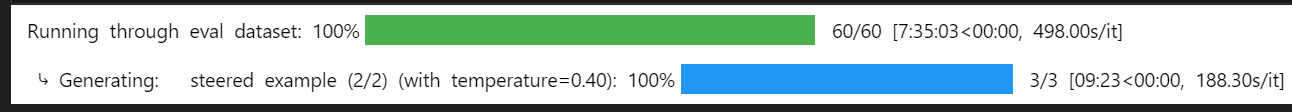

USMLE with 1300max tokens takes substantially longer: 
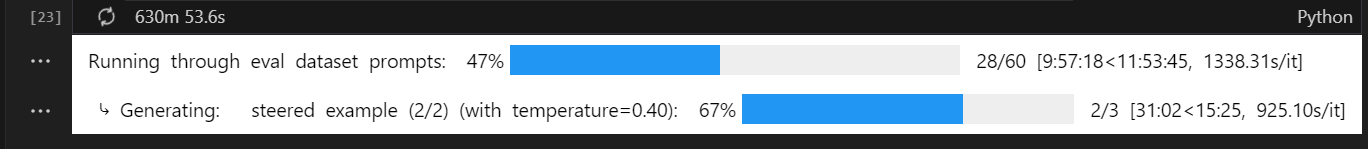

Stopped it..
![image-3.png](attachment:image-3.png)

# Log / Diary of Runs with V2_looped:
cancelled run V2 and made new run: V2_Fixed because the steering coeff was permanently set to 1. 
The results may still be slightly interesting, SHOULD the steered answer 2 be wrong in some cases, due to the temperature and mostly the **FREQUENCY PENALTY** setting. 
I guess this was a good experiment to see the effect of that setting.
Reduced it substantially for the v2_fixed run and reduced amount of prompts because it took almost 2 days to run.

2h27 for hotpot.

usmle pirate:

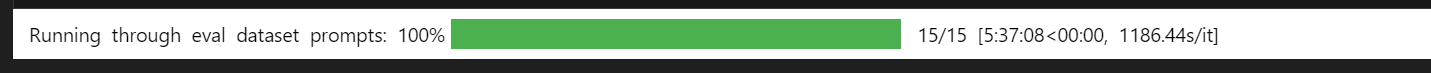

usmle negative:

--> however, steering coefficient was way too high. Answers are super long and nonsensical. Wouldn't have happened with a better chosen coefficient, it was just always using all 1300 Tokens.

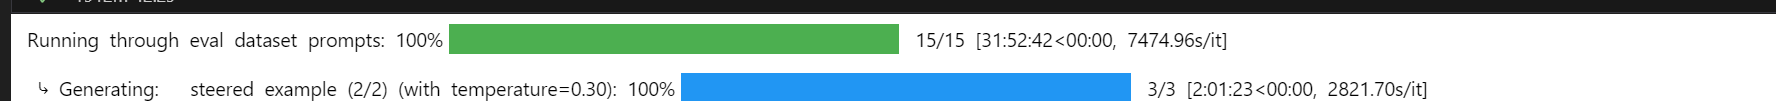